# Import library

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as spark_sum, year, hour, count, isnan, when, avg, round, explode
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.recommendation import ALS
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator

StatementMeta(spark1, 15, 2, Finished, Available)

# Load data

In [3]:
customers = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_customers_dataset.csv', format='csv', header=True, inferSchema = True)
geolocation = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_geolocation_dataset.csv', format='csv', header=True, inferSchema = True)
orderItems = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_order_items_dataset.csv', format='csv', header=True, inferSchema = True)
orderPayments = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_order_payments_dataset.csv', format='csv', header=True, inferSchema = True)
orderReviews = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_order_reviews_dataset.csv', format='csv', header=True, inferSchema = True)
orders = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_orders_dataset.csv', format='csv', header=True, inferSchema = True)
products = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_products_dataset.csv', format='csv', header=True, inferSchema = True)
sellers = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_sellers_dataset.csv', format='csv', header=True, inferSchema = True)
nameTranslation = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/product_category_name_translation.csv', format='csv', header=True, inferSchema = True)
age = spark.read.load('abfss://datagroup6@datagroup6.dfs.core.windows.net/olist/olist_age.csv', format='csv', header=True, inferSchema = True)

StatementMeta(spark1, 15, 3, Finished, Available)

In [4]:
customers.show(5)
geolocation.show(5)
orderItems.show(5)
orderPayments.show(5)
orderReviews.show(5)
orders.show(5)
products.show(5)
sellers.show(5)
nameTranslation.show(5)
age.show(5)

StatementMeta(spark1, 15, 4, Finished, Available)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows

+---------------------------+-

# Data-preprocessing 

## Show the total number of null value per column of the dataset

In [5]:
dataset_names = ['customers', 'geolocation', 'orderItems', 'orderPayments', 'orderReviews', 'orders', 'products', 'sellers', 'nameTranslation', 'age']
datasets = [customers, geolocation, orderItems, orderPayments, orderReviews, orders, products, sellers, nameTranslation, age]

for dataset_name, dataset in zip (dataset_names, datasets):
    null_counts = dataset.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in dataset.columns])
    
    print("Dataset:", dataset_name)
    dataset.printSchema()
    null_counts.show(truncate=False)

StatementMeta(spark1, 15, 5, Finished, Available)

Dataset: customers
root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

+-----------+------------------+------------------------+-------------+--------------+
|customer_id|customer_unique_id|customer_zip_code_prefix|customer_city|customer_state|
+-----------+------------------+------------------------+-------------+--------------+
|0          |0                 |0                       |0            |0             |
+-----------+------------------+------------------------+-------------+--------------+

Dataset: geolocation
root
 |-- geolocation_zip_code_prefix: integer (nullable = true)
 |-- geolocation_lat: double (nullable = true)
 |-- geolocation_lng: double (nullable = true)
 |-- geolocation_city: string (nullable = true)
 |-- geolocation_state: string (nullable = true)

+-------------------

## Remove null value necessarily

In [6]:
orderReviews = orderReviews.filter(col('review_id').isNotNull() & col('order_id').isNotNull() & col('review_score').isNotNull())
products = products.filter(col('product_category_name').isNotNull())

null_counts1 = orderReviews.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in orderReviews.columns])
null_counts2 = products.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in products.columns])
print("Dataset:", "orderReviews")
null_counts1.show(truncate=False)
print("Dataset:", "products")
null_counts2.show(truncate=False)

StatementMeta(spark1, 15, 6, Finished, Available)

Dataset: orderReviews
+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+
|review_id|order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+
|0        |0       |0           |89721               |60700                 |6378                |6396                   |
+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+

Dataset: products
+----------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+-

# Processing data

In [7]:
orderReviews = orderReviews.filter(orderReviews['review_score'].isin([1, 2, 3, 4, 5]))
orderReviews = orderReviews.withColumn("review_score", orderReviews["review_score"].cast("int"))
orderReviews.printSchema()

StatementMeta(spark1, 15, 7, Finished, Available)

root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: string (nullable = true)
 |-- review_answer_timestamp: string (nullable = true)



# Save as Table

In [8]:
customers.write.mode("overwrite").saveAsTable("olist.customers")
geolocation.write.mode("overwrite").saveAsTable("olist.geolocation")
orderItems.write.mode("overwrite").saveAsTable("olist.orderItems")
orderPayments.write.mode("overwrite").saveAsTable("olist.orderPayments")
orderReviews.write.mode("overwrite").saveAsTable("olist.orderReviews")
orders.write.mode("overwrite").saveAsTable("olist.orders")
products.write.mode("overwrite").saveAsTable("olist.products")
sellers.write.mode("overwrite").saveAsTable("olist.sellers")
nameTranslation.write.mode("overwrite").saveAsTable("olist.nameTranslation")
age.write.mode("overwrite").saveAsTable("olist.age")

StatementMeta(spark1, 15, 8, Finished, Available)

# Frequency of purchase over the hour

In [9]:
orders_hour_year = orders.withColumn("order_year", year("order_purchase_timestamp"))
orders_hour_year = orders_hour_year.withColumn("order_hour", hour("order_purchase_timestamp"))

orders_per_hour_year = orders_hour_year.groupBy("order_year", "order_hour").count()
orders_per_hour_year = orders_per_hour_year.withColumn("average_per_hour", col("count") / 365)
orders_per_hour_year = orders_per_hour_year.withColumn("average_per_hour", round(col("average_per_hour"), 2))

display(orders_per_hour_year)

StatementMeta(spark1, 15, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, fdd58c65-5567-40d0-9289-1e9a0de9f9b3)

In [10]:
orders_per_hour_year.write.mode("overwrite").saveAsTable("olist.orders_per_hour_year")

StatementMeta(spark1, 15, 10, Finished, Available)

# Purchase quantity by location

In [11]:
customer_orders = customers.join(orders, 'customer_id', 'inner')

total_orders_per_city = customer_orders.groupBy('customer_city').agg(count('order_id').alias('total_orders'))

display(total_orders_per_city)

StatementMeta(spark1, 15, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 80de294e-1a2c-4343-a6cb-693b1e277954)

In [12]:
total_orders_per_city.write.mode("overwrite").saveAsTable("olist.total_orders_per_city")

StatementMeta(spark1, 15, 12, Finished, Available)

# Total sales during the year

In [13]:
order_price= orders.join(orderItems, 'order_id').distinct()
order_price = order_price.withColumn("year", year("order_purchase_timestamp"))

total_sales_per_year = order_price.groupBy("year").agg(spark_sum("price").alias("total_sales"))
total_sales_per_year = total_sales_per_year.withColumn("total_sales", round(col("total_sales"), 2))

total_sales_per_year.show(truncate=False)
display(total_sales_per_year)

StatementMeta(spark1, 15, 13, Finished, Available)

+----+-----------+
|year|total_sales|
+----+-----------+
|2018|7386050.8  |
|2016|49785.92   |
|2017|6155806.98 |
+----+-----------+



SynapseWidget(Synapse.DataFrame, 3b5ed39b-f2c4-45c6-9730-28cd74185c06)

In [14]:
total_sales_per_year.write.mode("overwrite").saveAsTable("olist.total_sales_per_year")

StatementMeta(spark1, 15, 14, Finished, Available)

# Main type of payment

In [15]:
paymenttype_count= orderPayments.groupBy('payment_type').count()
display(paymenttype_count)

StatementMeta(spark1, 15, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, b8a821d0-790d-4fe4-b0e4-49142d3cfc97)

In [16]:
paymenttype_count.write.mode("overwrite").saveAsTable("olist.paymenttype_count")

StatementMeta(spark1, 15, 16, Finished, Available)

# Review score

In [17]:
order_review= orderReviews.groupBy('review_score').count()

order_review.show(truncate=False)

StatementMeta(spark1, 15, 17, Finished, Available)

+------------+-----+
|review_score|count|
+------------+-----+
|1           |11388|
|3           |8172 |
|5           |57314|
|4           |19134|
|2           |3145 |
+------------+-----+



In [18]:
order_review.write.mode("overwrite").saveAsTable("olist.order_review")

StatementMeta(spark1, 15, 18, Finished, Available)

# Machine learning recommend product to customer using ALS algorithm

## Prepare data

In [19]:
product_rating_customer = orderItems.join(
    orderReviews,
    "order_id"
).join(
    products,
    "product_id"
).join(
    orders,
    "order_id"
).join(
    customers,
    "customer_id"
)
display(product_rating_customer)

StatementMeta(spark1, 15, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7fb5c870-8bda-48e2-94b8-2ad462535116)

In [20]:
product_rating_customer = product_rating_customer.withColumnRenamed("review_score", "rating").dropDuplicates()

# drop attribute is not needed
product_rating_customer = product_rating_customer.drop("shipping_limit_date","review_id","review_creation_date",
"review_answer_timestamp","order_status","order_purchase_timestamp","order_approved_at","order_delivered_carrier_date",
"order_delivered_customer_date","order_estimated_delivery_date","customer_unique_id")

# Create a function that converts customer_id and product_id to numbers
indexer_customer = StringIndexer(inputCol="customer_id", outputCol="customer_index").fit(customers)
indexer_product = StringIndexer(inputCol="product_id", outputCol="product_index").fit(products)

product_rating_customer = indexer_customer.transform(indexer_product.transform(product_rating_customer))

# Show data
print("Số lượng dữ liệu: ",product_rating_customer.count())
product_rating_customer.select("customer_index","product_index","rating").show(truncate=False)

StatementMeta(spark1, 15, 20, Finished, Available)

Số lượng dữ liệu:  110691
+--------------+-------------+------+
|customer_index|product_index|rating|
+--------------+-------------+------+
|54625.0       |29509.0      |5     |
|16018.0       |2518.0       |4     |
|25990.0       |3159.0       |1     |
|63584.0       |9120.0       |5     |
|90629.0       |21460.0      |5     |
|30127.0       |10468.0      |5     |
|40672.0       |22707.0      |5     |
|49716.0       |20702.0      |5     |
|92397.0       |25956.0      |5     |
|34493.0       |16038.0      |4     |
|47272.0       |24539.0      |5     |
|36769.0       |26300.0      |5     |
|61584.0       |3124.0       |5     |
|48973.0       |20551.0      |5     |
|94092.0       |6048.0       |4     |
|70709.0       |27852.0      |5     |
|30205.0       |25166.0      |5     |
|74909.0       |6350.0       |1     |
|93185.0       |23339.0      |5     |
|31496.0       |20104.0      |5     |
+--------------+-------------+------+
only showing top 20 rows



In [21]:
train, test = product_rating_customer.randomSplit([0.75, 0.25], seed=123)

print(f"Số lượng bản ghi trong tập huấn luyện: {train.cache().count()}")
print(f"Số lượng bản ghi trong tập kiểm tra: {test.cache().count()}")

StatementMeta(spark1, 15, 21, Finished, Available)

Số lượng bản ghi trong tập huấn luyện: 83193
Số lượng bản ghi trong tập kiểm tra: 27498


## Train model ALS

In [22]:
als = ALS(rank=10,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.05,
    coldStartStrategy='drop',
    nonnegative=True,
    seed=42,
    userCol="customer_index",
    itemCol="product_index",
    ratingCol="rating")
model_ALS = als.fit(train)

StatementMeta(spark1, 15, 22, Finished, Available)

## Evalution

In [23]:
predictions = model_ALS.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                               predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

StatementMeta(spark1, 15, 23, Finished, Available)

Root-mean-square error = 1.0897348937872262


In [24]:
predictions.select("customer_index","product_index","rating","prediction").show(truncate=False)

StatementMeta(spark1, 15, 24, Finished, Available)

+--------------+-------------+------+----------+
|customer_index|product_index|rating|prediction|
+--------------+-------------+------+----------+
|14779.0       |18232.0      |5     |4.982271  |
|32087.0       |4588.0       |5     |1.0636163 |
|23898.0       |1627.0       |5     |4.982867  |
|25540.0       |17929.0      |5     |4.982853  |
|18029.0       |1650.0       |1     |0.14219786|
|17326.0       |8254.0       |5     |4.9827023 |
|4297.0        |7002.0       |1     |2.4640172 |
|93013.0       |15753.0      |5     |4.98013   |
|59041.0       |19472.0      |5     |4.978194  |
|98467.0       |9362.0       |4     |3.9755208 |
|23689.0       |11983.0      |5     |4.9838357 |
|26717.0       |28778.0      |5     |4.9819956 |
|26472.0       |29153.0      |5     |4.98138   |
|29078.0       |20950.0      |5     |4.9730706 |
|6609.0        |24041.0      |5     |4.979149  |
|61639.0       |9054.0       |4     |3.9786572 |
|1011.0        |14617.0      |1     |0.99424607|
|22732.0       |3199

## Recommend product

In [25]:
# Recommend 5 product for each customer
recommendations = model_ALS.recommendForAllUsers(5)
recommendations = recommendations.select("customer_index", col("recommendations.product_index").alias("recommended_products"))
recommendations = recommendations.withColumn("recommended_product", explode(col("recommended_products")))

# Transfer index to id
index_to_string_customer = IndexToString(inputCol="customer_index", outputCol="customer_id", labels=indexer_customer.labels)
recommendations = index_to_string_customer.transform(recommendations)
 
index_to_string_product = IndexToString(inputCol="recommended_product", outputCol="recommended_product_id", labels=indexer_product.labels)
recommendations = index_to_string_product.transform(recommendations)

# Join product dataset
recommendations = recommendations.join(products, recommendations.recommended_product_id == products.product_id, "inner")
# recommendations = recommendations.select("customer_id","recommended_product_id","product_category_name")

# Show
recommendations.select("customer_index","recommended_product","product_category_name").show(truncate=False)

StatementMeta(spark1, 15, 25, Finished, Available)

+--------------+-------------------+---------------------------+
|customer_index|recommended_product|product_category_name      |
+--------------+-------------------+---------------------------+
|26            |10653              |automotivo                 |
|26            |19139              |utilidades_domesticas      |
|26            |14227              |informatica_acessorios     |
|26            |4507               |brinquedos                 |
|26            |25402              |bebes                      |
|27            |24541              |fashion_bolsas_e_acessorios|
|27            |13534              |beleza_saude               |
|27            |26356              |moveis_decoracao           |
|27            |26320              |beleza_saude               |
|27            |25540              |casa_conforto              |
|28            |24044              |fashion_bolsas_e_acessorios|
|28            |16333              |automotivo                 |
|28            |31650    

In [26]:
recommendations.write.mode("overwrite").saveAsTable("olist.recommendations")

StatementMeta(spark1, 15, 26, Finished, Available)

# Machine learning customer segmentation using Kmean

### To apply clustering using K-means, the dataframe must meet certain conditions. These conditions include:

* No Missing Values: The dataframe should not contain missing or null values as K-means cannot handle them directly.
* Numeric Variables: The dataframe should predominantly consist of numeric variables.
* Relevant Columns: The dataframe should include only columns relevant to the clustering analysis.
* No Identification Variables: Identification variables, such as unique identifiers or names, should be avoided in the dataframe used for K-means clustering.
* Standardized or Normalized Variables: It is advisable to standardize or normalize numeric variables before applying K-means.

## Data processing

In [27]:
customer_age = customers.join(age, on='customer_id')
order_payments = orderPayments.join(orders, on='order_id')

total_spent = order_payments.groupBy('customer_id').agg(F.sum('payment_value').alias('total_spent'))

customer_data = customer_age.join(total_spent, on='customer_id')

# Select age and total_spent
customer_data = customer_data.select("customer_id", "age", "total_spent")

# Show
customer_data.printSchema()
null_counts1 = customer_data.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in customer_data.columns])
print("Count null value:")
null_counts1.show(truncate=False)
print("Dataset: Customer data")
customer_data.show(truncate=False)

StatementMeta(spark1, 15, 27, Finished, Available)

root
 |-- customer_id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- total_spent: double (nullable = true)

Count null value:
+-----------+---+-----------+
|customer_id|age|total_spent|
+-----------+---+-----------+
|0          |0  |0          |
+-----------+---+-----------+

Dataset: Customer data
+--------------------------------+---+------------------+
|customer_id                     |age|total_spent       |
+--------------------------------+---+------------------+
|f54a9f0e6b351c431402b8461ea51999|75 |35.95             |
|2a1dfb647f32f4390e7b857c67458536|44 |508.17            |
|4f28355e5c17a4a42d3ce2439a1d4501|53 |153.72            |
|4632eb5a8f175f6fe020520ae0c678f3|37 |91.66             |
|843ff05b30ce4f75b6170b39c78a8ee5|70 |102.74            |
|a4156bb8aff5d6722dc68f605d8fa241|75 |206.87            |
|1099d033c74a027a78c1d26e1de9c8ad|64 |61.7              |
|7a3bd3b37285f0ab25983420cbd01f4e|39 |473.12            |
|5fff39f1b59dc4d2fb96c9f19b9a484e|50 |90.5

## Draw boxplot

StatementMeta(spark1, 15, 28, Finished, Available)

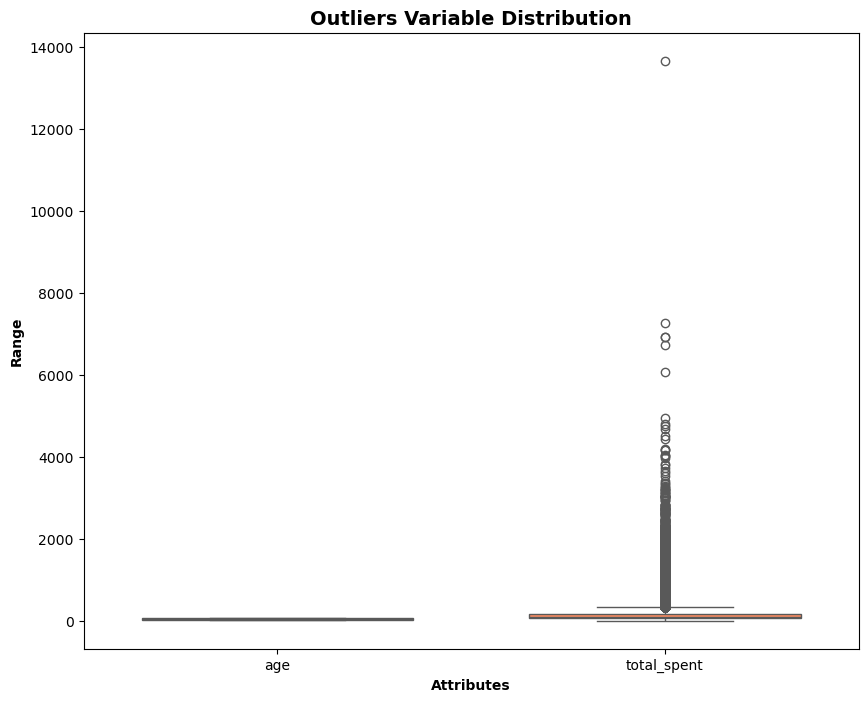

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the default figure size for the boxplot
plt.rcParams['figure.figsize'] = [10, 8]

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = customer_data.toPandas()

# Create a boxplot using Seaborn
sns.boxplot(data=pandas_df, orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)

# Set the title of the boxplot
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')

# Label the y-axis of the boxplot
plt.ylabel("Range", fontweight='bold')

# Label the x-axis of the boxplot
plt.xlabel("Attributes", fontweight='bold')

# Show the boxplot
plt.show()

##### After creating a boxplot, we notice outliers in the 'total_spent' variable. The values spike up to approximately 14000. Therefore, we need to remove them.

## Remove Outliers

In [29]:
from pyspark.sql.functions import col

def remove_outliers(df, column):
    # Calculate quantile values
    quantiles = df.approxQuantile(column, [0.05, 0.95], 0.01)  # Sử dụng approxQuantile để xấp xỉ giá trị quantile
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    
    # Calculate the IQR range
    IQR = Q3 - Q1
    
    # Calculate the lower and upper limits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data
    df_filtered = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    return df_filtered


# Apply the function for Total_spent
customer_data = remove_outliers(customer_data, 'total_spent')

StatementMeta(spark1, 15, 29, Finished, Available)

## Draw boxplot

StatementMeta(spark1, 15, 30, Finished, Available)

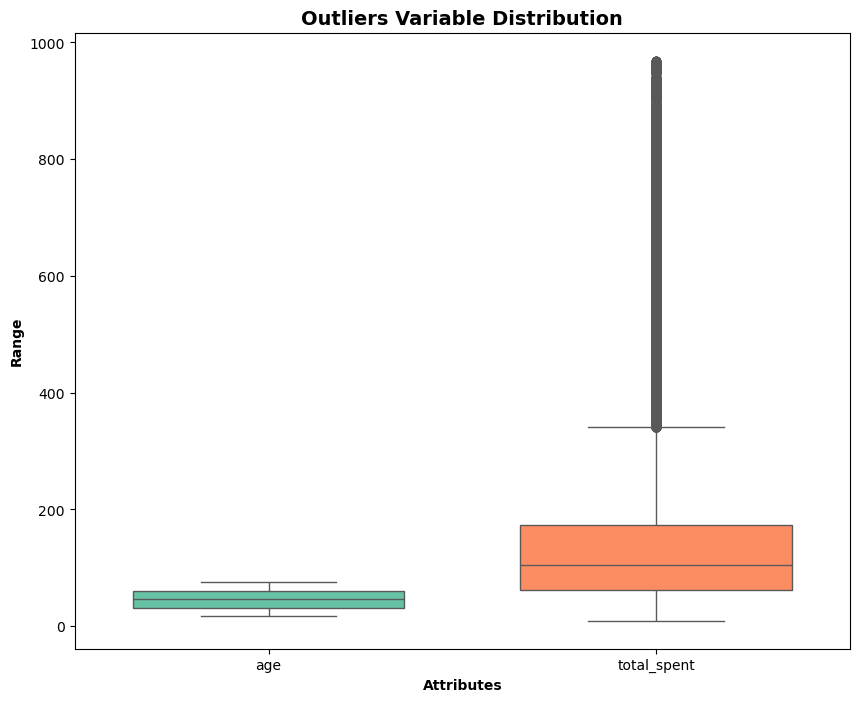

In [30]:
plt.rcParams['figure.figsize'] = [10, 8]
pandas_df = customer_data.toPandas()
sns.boxplot(data=pandas_df, orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')
plt.show()

Outliers are still observed, but they are less extreme than those presented in the previous graph. It is chosen to retain them to increase the diversity of the data, which in turn can enrich the analyses and models by capturing a broader range of possible scenarios and outcomes.

## Database normalisation

In [31]:
# Create a VectorAssembler to aggregate the total_spent and age columns
assembler = VectorAssembler(inputCols=['total_spent', 'age'], outputCol='features')
customer_data_features = assembler.transform(customer_data)

# Use StandardScaler to normalize data
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
scaler_model = scaler.fit(customer_data_features)
scaled_data = scaler_model.transform(customer_data_features)

# Displays normalized data
scaled_data.show(truncate=False)

StatementMeta(spark1, 15, 31, Finished, Available)

+--------------------------------+---+-----------+-------------+----------------------------------------+
|customer_id                     |age|total_spent|features     |scaledFeatures                          |
+--------------------------------+---+-----------+-------------+----------------------------------------+
|01d190d14b00073f76e0a5ec46166352|19 |258.74     |[258.74,19.0]|[1.9543732303700303,1.1341877761579315] |
|03a7750fc7a7bfbd7a84b2f4f26b92f1|41 |198.1      |[198.1,41.0] |[1.4963335276196297,2.4474578327618524] |
|04495037fc6899faffa41ba3bc4272b4|69 |265.04     |[265.04,69.0]|[2.0019598089869093,4.118892450257752]  |
|04b7d26bde4f2d2fee0043ef81e664b1|53 |372.56     |[372.56,53.0]|[2.814104084048305,3.163786954545809]   |
|04cef6b920c0d8f16702cab269b59044|56 |340.72     |[340.72,56.0]|[2.573603026403636,3.3428692349917983]  |
|06199a7981ec145069afeb0baf66a49b|72 |55.38      |[55.38,72.0] |[0.41830868631789553,4.297974730703741] |
|0632cb63610a5d7d5da9a4fb595dd101|65 |113.42  

## Train model with number of cluster k=3

In [32]:
k = 3  # Change k value according to need

# Initialize the k-means model
kmeans = KMeans(k=k, seed=1, featuresCol='scaledFeatures')
model = kmeans.fit(scaled_data)

# Cluster prediction for each customer
predictions = model.transform(scaled_data)

# Show
predictions.show(truncate=False)

StatementMeta(spark1, 15, 32, Finished, Available)

+--------------------------------+---+-----------+-------------+----------------------------------------+----------+
|customer_id                     |age|total_spent|features     |scaledFeatures                          |prediction|
+--------------------------------+---+-----------+-------------+----------------------------------------+----------+
|01d190d14b00073f76e0a5ec46166352|19 |258.74     |[258.74,19.0]|[1.9543732303700303,1.1341877761579315] |1         |
|03a7750fc7a7bfbd7a84b2f4f26b92f1|41 |198.1      |[198.1,41.0] |[1.4963335276196297,2.4474578327618524] |1         |
|04495037fc6899faffa41ba3bc4272b4|69 |265.04     |[265.04,69.0]|[2.0019598089869093,4.118892450257752]  |0         |
|04b7d26bde4f2d2fee0043ef81e664b1|53 |372.56     |[372.56,53.0]|[2.814104084048305,3.163786954545809]   |2         |
|04cef6b920c0d8f16702cab269b59044|56 |340.72     |[340.72,56.0]|[2.573603026403636,3.3428692349917983]  |2         |
|06199a7981ec145069afeb0baf66a49b|72 |55.38      |[55.38,72.0] |

## Evaluate model

In [33]:
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean')
score=evaluator.evaluate(predictions) 
print('Silhouette Score for 3 =', score)

StatementMeta(spark1, 15, 33, Finished, Available)

Silhouette Score for 3 = 0.6569170465663882


## Save

In [34]:
predictions_cluster = predictions.select("customer_id", "age", "total_spent", "prediction")
predictions_cluster = predictions_cluster.coalesce(1)
predictions_cluster.write.mode("overwrite").option("header", "true").saveAsTable("olist.predictions_cluster")

StatementMeta(spark1, 15, 34, Finished, Available)

## Visualize

StatementMeta(spark1, 15, 35, Finished, Available)

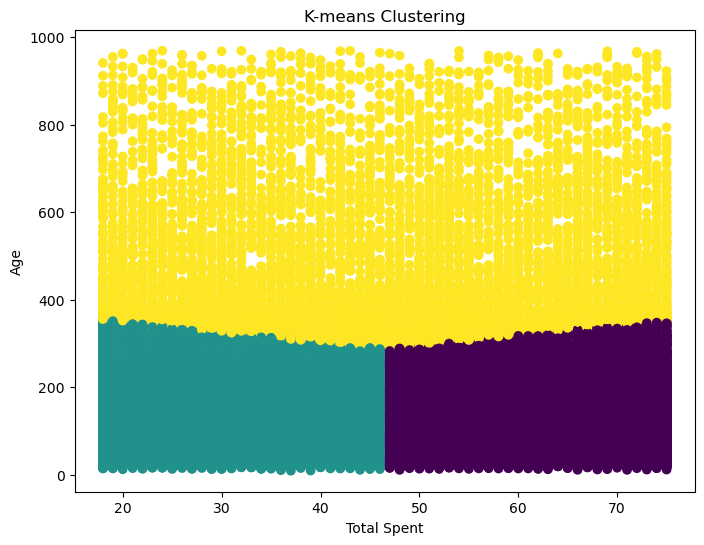

In [35]:
# Convert Spark dataframe to Pandas dataframe for chart
predictions_pandas = predictions.select("total_spent", "age", "prediction").toPandas()

# Draw scatter plot char
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pandas['age'],
            predictions_pandas['total_spent'],
            c=predictions_pandas['prediction'], cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Total Spent')
plt.ylabel('Age')
plt.show()


## Statistical

In [36]:
# statistical calculations
cluster_analysis = predictions.groupBy('prediction') \
    .agg(
        F.sum('total_spent').alias('sum_total_spent'),
        F.mean('total_spent').alias('avg_total_spent'),
        F.mean('age').alias('avg_age')
    )

# Round the age after statistical calculations
cluster_analysis = cluster_analysis.withColumn("avg_age", round(cluster_analysis["avg_age"].cast("integer")))

# Displays statistics for each cluster
cluster_analysis.show(truncate=False)

StatementMeta(spark1, 15, 36, Finished, Available)

+----------+------------------+------------------+-------+
|prediction|sum_total_spent   |avg_total_spent   |avg_age|
+----------+------------------+------------------+-------+
|1         |5011017.840000006 |111.87555178495694|31     |
|2         |3939785.5999999954|495.75759406065123|46     |
|0         |5018869.879999999 |112.22122576750216|61     |
+----------+------------------+------------------+-------+

